In [12]:
import neo
from neo import utils
import quantities as pq
import numpy as np
# import elephant.time_warping as tw
from elephant.signal_processing import wavelet_transform
from collections import defaultdict
# import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from pathlib import Path

In [13]:
import importlib
import sys

sys.path.append('/home/chebrol/tools/vision4action/')
# sys.path.append('/users/essink/projects/vision4action/vision4action')
# sys.path.append('/home/ito/toolbox/vision4action')
import v4a
from v4a.plot import plotting_functions, plotting_utils

In [14]:
nix_file = '/home/chebrol/nix_folder/y180306-land-001_small.nix'
# nix_file = '/projects/v4a-curation/test_all_sessions/y180306-land-001/y180306-land-001_small.nix'
# nix_file = '/home/ito/datasets/marseille/congloue/data/Vision4Action/DataV4A/y180306-land-001/y180306-land-001_small.nix'

with neo.NixIO(nix_file, 'ro') as io:
    blocks = io.read_all_blocks()

In [15]:
# Analysis parameters

pre = -200 * pq.ms
post = 1500 * pq.ms

# areas to analyze
block_id = 0 # motor
# block_id = 1 # visual
seg_id = 1
anasig_id = 3


# The frequency and nco variables are for the wavelet transform to be done on the analog signals collected.
freq = 256 # motor
# freq = 128 # visual
nco = 6.0

In [16]:
# loading data
block = blocks[block_id]
seg = block.segments[seg_id]
anasig = seg.analogsignals[anasig_id]
sampling_rate = anasig.sampling_rate.rescale("Hz").magnitude
channel_names = anasig.array_annotations["channel_names"]
channel_ids = anasig.array_annotations['channel_ids']

channel_idx = channel_ids - 1
channel_idx = channel_idx.tolist()
sig_wavelet = wavelet_transform(signal=anasig[:,channel_idx], frequency=freq, n_cycles=nco, fs=sampling_rate)
pow_wavelet = np.abs(sig_wavelet) ** 2
pow_normed = pow_wavelet / pow_wavelet.mean()

In [17]:
transformed_anasig = anasig.duplicate_with_new_data(pow_normed)
transformed_anasig.name = "normed_wavelet_transformed_lfp"
del transformed_anasig.annotations['nix_name']
for key, val in anasig.array_annotations.items():
    if len(val):
        transformed_anasig.annotations[key] = val[channel_idx]
anasig.segment.analogsignals.append(transformed_anasig)
seg.create_relationship()

In [18]:
trigger_event = 'target_02_on'
trigger_events = utils.get_events(container=seg,
                                name='DecodedEvents',
                                labels=trigger_event,
                                in_successful_trial=True,
                                # trial_protocol=trial_protocol
                                )[0]

In [19]:
epoch = utils.add_epoch(
    seg,
    event1=trigger_events, event2=None,
    pre=pre, post=post,
    attach_result=False,
    name='analysis_epochs')

In [20]:
target_02_on_segs = utils.cut_segment_by_epoch(
    seg=seg,
    epoch=epoch,
    reset_time=True)

target_02_on_block = neo.Block(name='Block with target_02_on trigger as segments')
target_02_on_block.segments = target_02_on_segs
target_02_on_block.create_relationship()

In [21]:
for attempt in target_02_on_block.segments:
    attempt = plotting_utils.define_hand_movement_events(attempt, onset_and_offset=False)
    attempt = plotting_utils.define_eye_movement_events(attempt, onset_and_offset=False)
    attempt = plotting_utils.define_first_behavior_onsets_after_target_on(attempt,
                                             behavior='eye',
                                             targets=[2],
                                             saccade_plausibility_buffer=150*pq.ms)

    attempt = plotting_utils.define_first_behavior_onsets_after_target_on(attempt,
                                             behavior='hand',
                                             targets=[2],
                                             movement_plausibility_buffer=-100*pq.ms,
                                             movement_choice='largest_peak_velocity')



In [22]:
marker_color = {
    'target_01_on': 'C0',
    # 'hand_enters_target_01',
    'target_01_reached': 'C0',
    'target_02_on': 'C1',
    'sacc. onset after target 2': 'C4',
    'hand onset after target 2': 'C5', 
    # 'hand_enters_target_02',
    'target_02_reached': 'C1',
    'target_03_on': 'C2',
    'sacc. onset after target 3': 'C4',
    'hand onset after target 3': 'C5',
    # 'hand_enters_target_03',
    'target_03_reached': 'C2',
    'target_04_on': 'C3',
    'sacc. onset after target 4': 'C4',
    'hand onset after target 4': 'C5',
    # 'hand_enters_target_04',
    'target_04_reached': 'C3',
}

marker_alpha = {
    'target_01_on': 1,
    # 'hand_enters_target_01',
    'target_01_reached': 0.5,
    'target_02_on': 1,
    'sacc. onset after target 2': 1,
    'hand onset after target 2': 1, 
    # 'hand_enters_target_02',
    'target_02_reached': 0.5,
    'target_03_on': 1,
    'sacc. onset after target 3': 1,
    'hand onset after target 3': 1,
    # 'hand_enters_target_03',
    'target_03_reached': 0.5,
    'target_04_on': 1,
    'sacc. onset after target 4': 1,
    'hand onset after target 4': 1,
    # 'hand_enters_target_04',
    'target_04_reached': 0.5,
}

marker_style = {
    'target_01_on': 7,
    # 'hand_enters_target_01',
    'target_01_reached': 7,
    'target_02_on': 7,
    'sacc. onset after target 2': "8",
    'hand onset after target 2': 'X', 
    # 'hand_enters_target_02',
    'target_02_reached': 7,
    'target_03_on': 7,
    'sacc. onset after target 3': "8",
    'hand onset after target 3': 'X',
    # 'hand_enters_target_03',
    'target_03_reached': 7,
    'target_04_on': 7,
    'sacc. onset after target 4': "8",
    'hand onset after target 4': 'X',
    # 'hand_enters_target_04',
    'target_04_reached': 7,
}

plot_events_dict = defaultdict(dict)
plot_events_dict['marker_color'] = marker_color
plot_events_dict['marker_alpha'] = marker_alpha
plot_events_dict['marker_style'] = marker_style


In [23]:
segment_id = 1
epoch_id = 2

target_dict = plotting_utils.get_target_dict_from_block(blocks[block_id])
sequence_dict = plotting_utils.get_sequence_dict_from_epoch(blocks[block_id].segments[segment_id].epochs[epoch_id])

In [24]:
importlib.reload(plotting_functions)
importlib.reload(plotting_utils)

<module 'v4a.plot.plotting_utils' from '/home/chebrol/tools/vision4action/v4a/plot/plotting_utils.py'>

In [25]:
#lfps = []
#for attempt in target_02_on_block.segments:
 #   transformed_anasig = attempt.analogsignals[-1]
  #  assert(transformed_anasig.name == "normed_wavelet_transformed_lfp")
   # lfps.append(transformed_anasig)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


KeyError: False

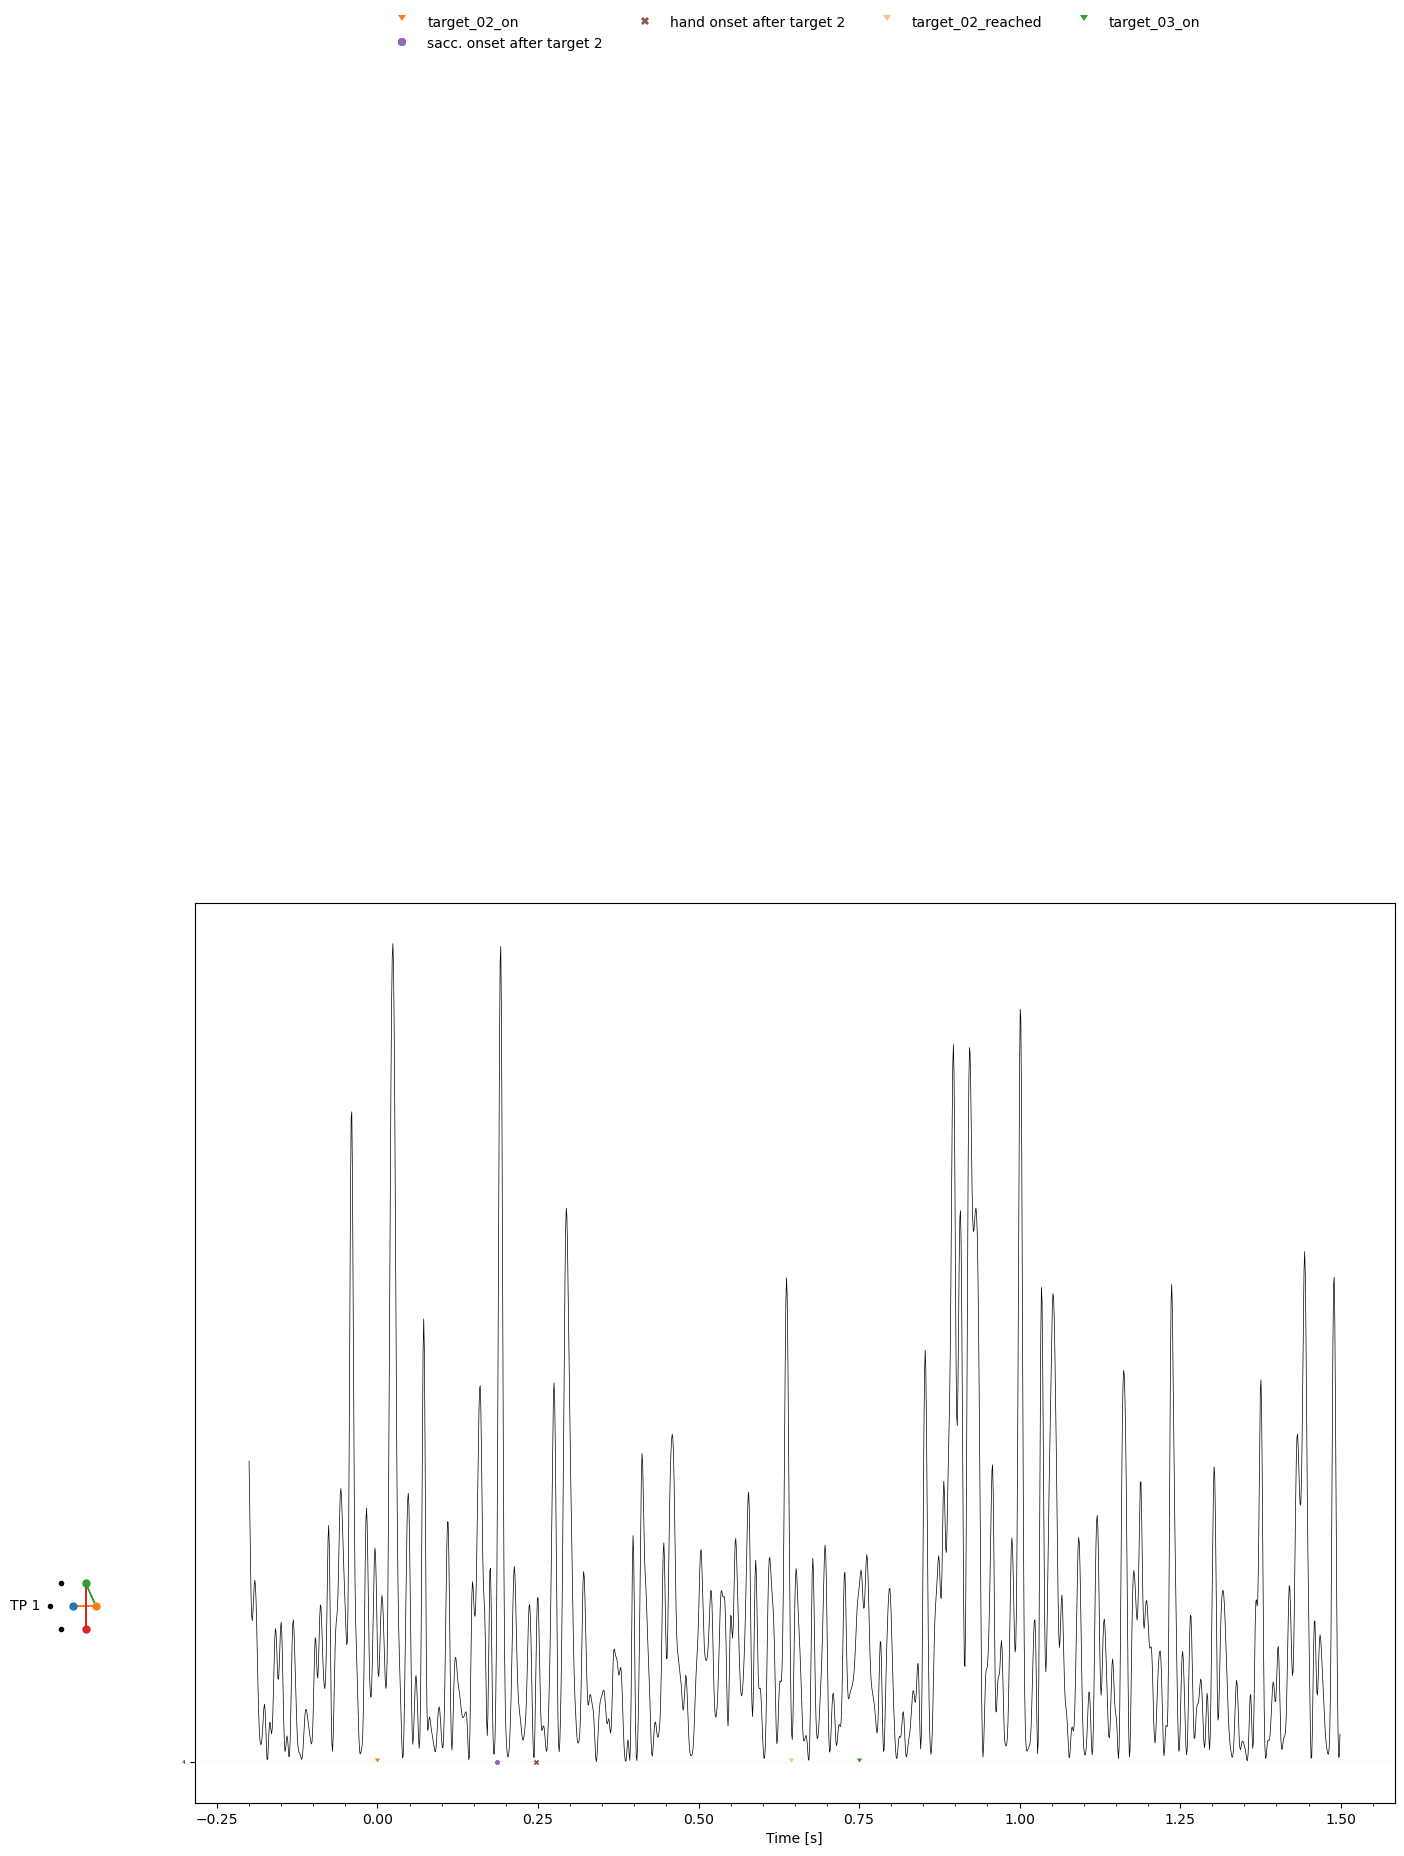

In [35]:
figure_destination = 'output'


lfps = []
ch_id = 10
print(channel_idx)
for ch_id in channel_ids:
    for attempt in target_02_on_block.segments:
        transformed_anasig = attempt.analogsignals[-1][:, ch_id]
        assert(transformed_anasig.name == "normed_wavelet_transformed_lfp")
        for key, val in anasig.array_annotations.items():
            if len(val):
                transformed_anasig.annotations[key] = val[channel_idx]
        lfps.append(transformed_anasig)
        fig = plotting_functions.plot_lfp_trials_sorted_by_protocol(
        lfps=lfps,
        figure_destination=figure_destination,
        sequence_dict=sequence_dict,
        target_dict=target_dict,
        plot_events=plot_events_dict,
        plot_insets=True,
        event_colormap=plot_events_dict['colormap'], #cc.glasbey_cool
        trial_protocols=np.arange(1,13), #[7,8], # can also take a list e.g. [1,4,5],
        plot_warping_function_shade=False,
        fixed_warping_shade_limit=False,
        sort_segments_by=['target_02_on', 'sacc. onset after target 2'],
        ch_id=ch_id,
        time_shift=-200*pq.ms,
        frequency=freq*pq.Hz,
        gridspec_args={
            'wspace': 0.0,
            'hspace': 0.0,
            'top': 0.95,
            'bottom': 0.05,
            'left': 0.1,
            'right': 0.9
        },
        inset_axes_dict={
            'width': 0.5,
            'height': 0.5,
            'loc': 'lower right',
            'borderpad': 0},
        legend_dict={
            'bbox_to_anchor' : (0.5, 2)
            },
        lfp_style={
            'color': 'black',
            'linewidth': 0.5,
            'alpha': 1,        
            },
        horizontal_inset_padding = -0.15,
        figsize=(15,10),
        darkmode=False,
        save_plot=True,
        verbose=True
        )
        

KeyError: False

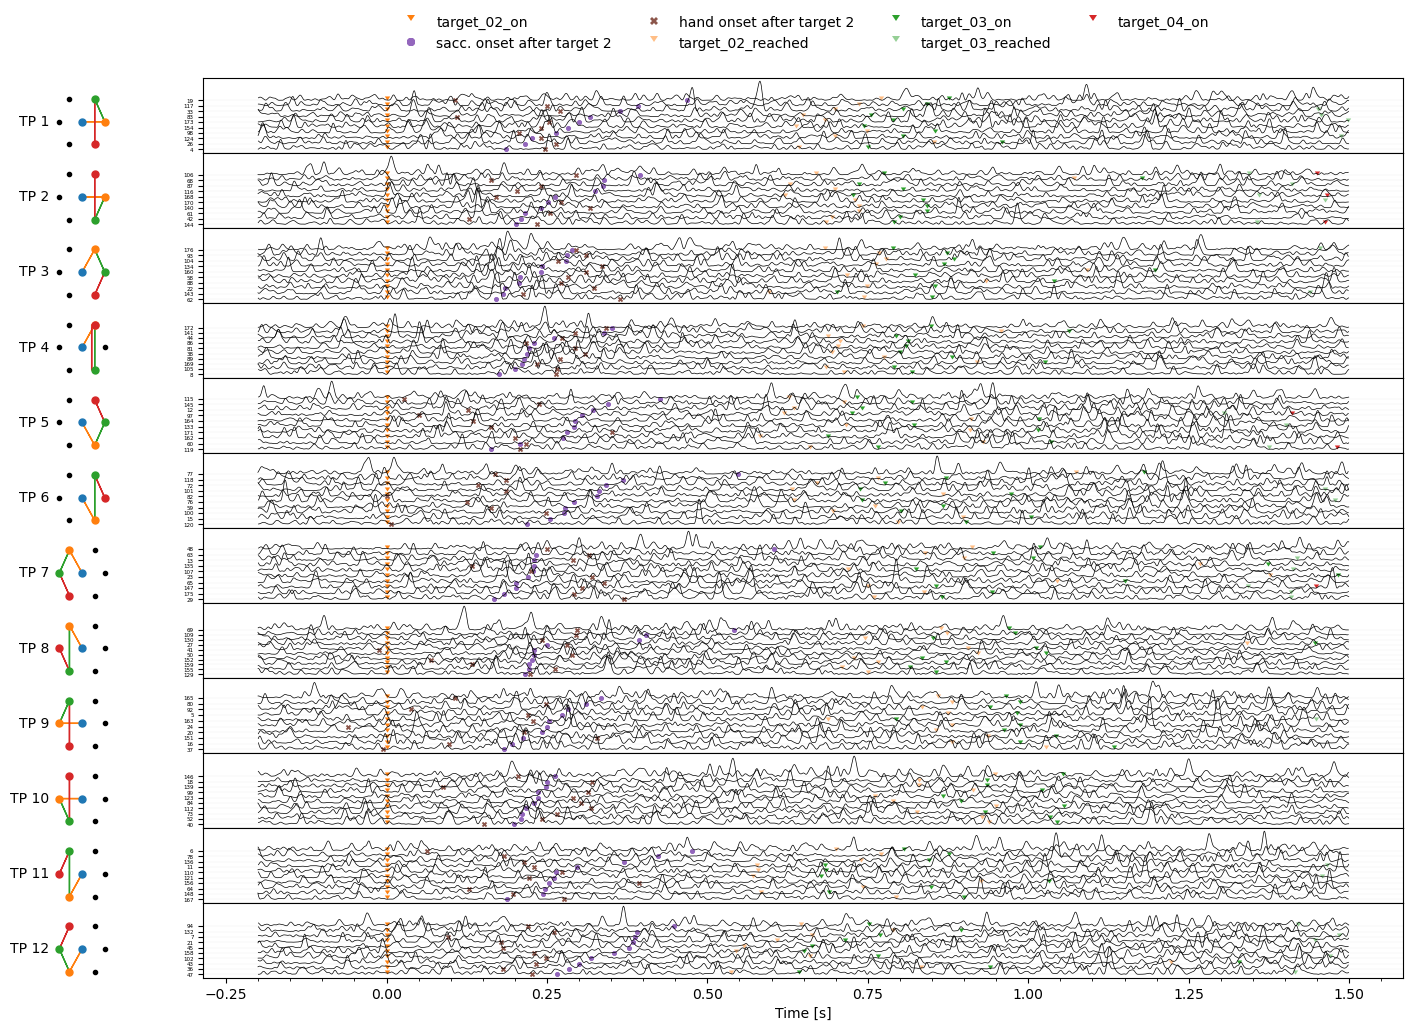

In [37]:

fig = plotting_functions.plot_lfp_trials_sorted_by_protocol(
    lfps=lfps,
    figure_destination=figure_destination,
    sequence_dict=sequence_dict,
    target_dict=target_dict,
    plot_events=plot_events_dict,
    plot_insets=True,
    event_colormap=plot_events_dict['colormap'], #cc.glasbey_cool
    trial_protocols=np.arange(1,13), #[7,8], # can also take a list e.g. [1,4,5],
    plot_warping_function_shade=False,
    fixed_warping_shade_limit=False,
    sort_segments_by=['target_02_on', 'sacc. onset after target 2'],
    ch_id=ch_id,
    time_shift=-200*pq.ms,
    frequency=freq*pq.Hz,
    gridspec_args={
        'wspace': 0.0,
        'hspace': 0.0,
        'top': 0.95,
        'bottom': 0.05,
        'left': 0.1,
        'right': 0.9
    },
    inset_axes_dict={
        'width': 0.5,
        'height': 0.5,
        'loc': 'lower right',
        'borderpad': 0},
    legend_dict={
        'bbox_to_anchor' : (0.5, 2)
        },
    lfp_style={
        'color': 'black',
        'linewidth': 0.5,
        'alpha': 1,        
        },
    horizontal_inset_padding = -0.15,
    figsize=(15,10),
    darkmode=False,
    save_plot=True,
    verbose=True
    )

KeyError: False

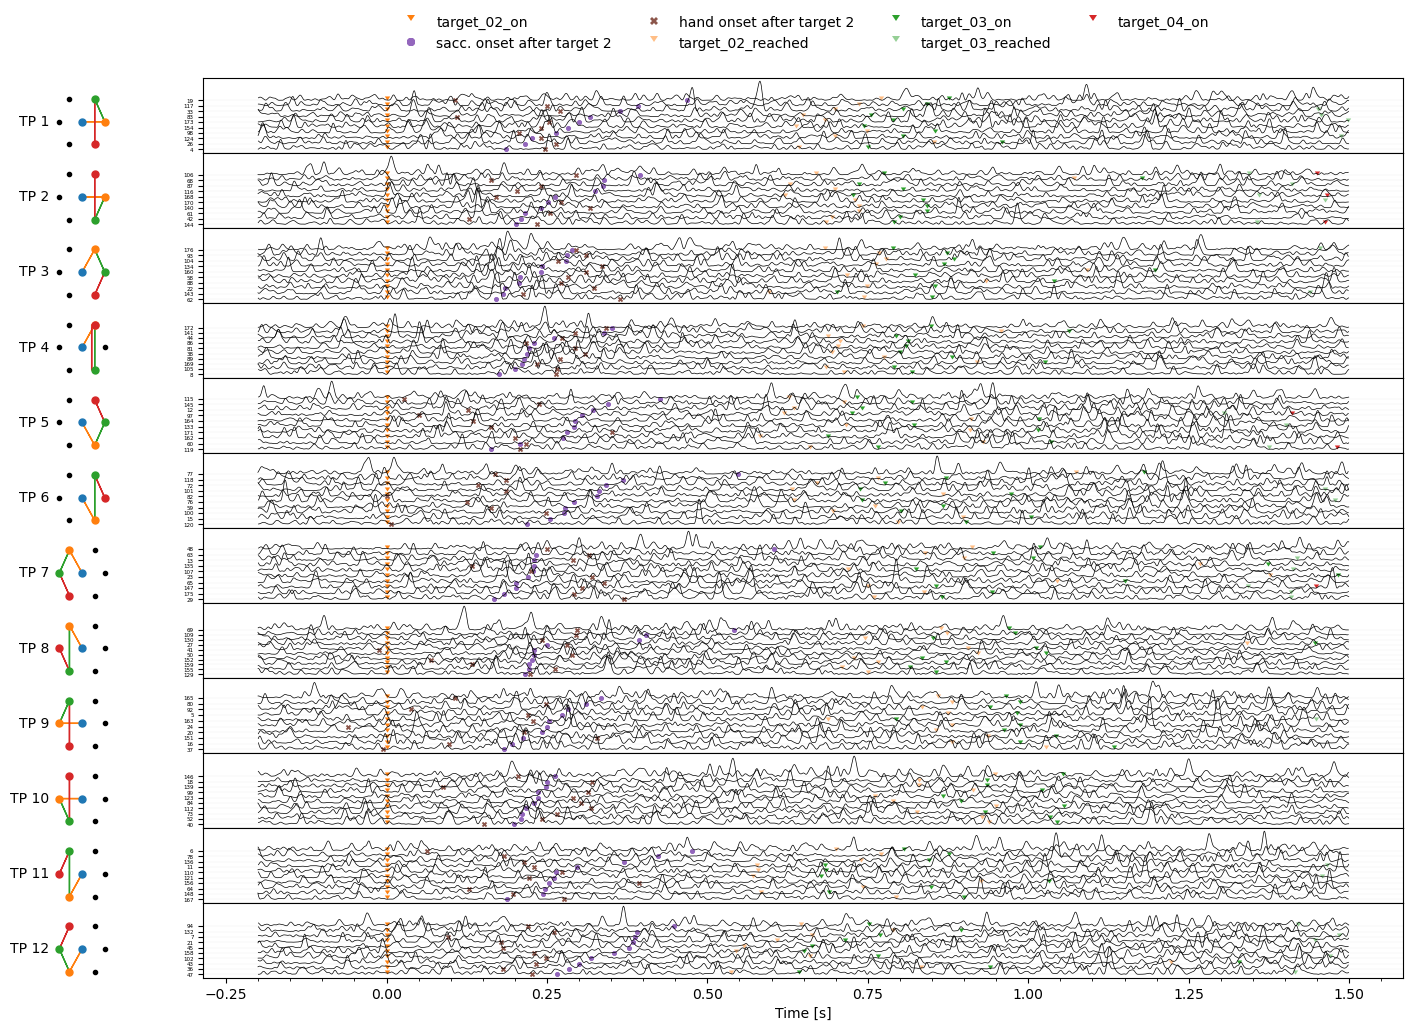

In [38]:
lfps = []
ch_id = 10
for attempt in target_02_on_block.segments:
    transformed_anasig = attempt.analogsignals[-1][:, ch_id]
    assert(transformed_anasig.name == "normed_wavelet_transformed_lfp")
    for key, val in anasig.array_annotations.items():
        if len(val):
            transformed_anasig.annotations[key] = val[channel_idx]
    lfps.append(transformed_anasig)

fig = plotting_functions.plot_lfp_trials_sorted_by_protocol(
    lfps=lfps,
    figure_destination=figure_destination,
    sequence_dict=sequence_dict,
    target_dict=target_dict,
    plot_events=plot_events_dict,
    plot_insets=True,
    event_colormap=plot_events_dict['colormap'], #cc.glasbey_cool
    trial_protocols=np.arange(1,13), #[7,8], # can also take a list e.g. [1,4,5],
    plot_warping_function_shade=False,
    fixed_warping_shade_limit=False,
    sort_segments_by=['target_02_on', 'sacc. onset after target 2'],
    ch_id=ch_id,
    time_shift=-200*pq.ms,
    frequency=freq*pq.Hz,
    gridspec_args={
        'wspace': 0.0,
        'hspace': 0.0,
        'top': 0.95,
        'bottom': 0.05,
        'left': 0.1,
        'right': 0.9
    },
    inset_axes_dict={
        'width': 0.5,
        'height': 0.5,
        'loc': 'lower right',
        'borderpad': 0},
    legend_dict={
        'bbox_to_anchor' : (0.5, 2)
        },
    lfp_style={
        'color': 'black',
        'linewidth': 0.5,
        'alpha': 1,        
        },
    horizontal_inset_padding = -0.15,
    figsize=(15,10),
    darkmode=False,
    save_plot=True,
    verbose=True
    )